> 🩺 Este notebook forma parte del proyecto **NutriSynthCare**, un entorno de simulación sobre salud pública y recomendaciones nutricionales personalizadas.  
>
> 👥 Desarrollado por:  
> - Daniel Cruz – [dCruzCoding](https://github.com/dCruzCoding)  
> - Aníbal García – [Aniballll](https://github.com/Aniballll)  
>
> 📁 Repositorio completo: [NutriSynthCare](https://github.com/dCruzCoding/NutriSynthCare)  
>
> 📜 Licencia: Este proyecto está disponible bajo la licencia MIT. Consulta el archivo `LICENSE` para más información.  
>
> 🙏 Agradecimientos especiales a todas las fuentes de datos y literatura científica que han hecho posible la creación de las bases sintéticas utilizadas en este proyecto.  
>
> 🤝 ¿Te interesa colaborar? ¡Estás invitado!  
> Puedes contribuir mejorando los notebooks, proponiendo nuevas ideas o corrigiendo errores:  
> - Haz un fork del repo  
> - Crea una rama (`git checkout -b mejora/nueva-idea`)  
> - Abre un Pull Request explicando tu propuesta

# =========================================================================
# ⚙️ PIPELINE DE LA GENERACIÓN DE LA BASE DE DATOS
# RIESGO CARDIOVASCULAR ❤️ EN PERSONAS CON DIABETES 🩸
# =========================================================================

```text
+---------------------------------+      +-----------------------------------------+
|    DB Sintética 1: Diabetes     |      |  DB Sintética 2: Riesgo Cardiovascular  |
+---------------------------------+      +-----------------------------------------+
             |                                              |
             '--------------------. .-----------------------'
                                  |
                                  v
                  +--------------------------------+
                  |    1. UNIÓN DE BASES DE DATOS  |
                  |     (Outer Join por columnas   |
                  |           comunes)             |
                  +--------------------------------+
                                  |
                                  v
        +---------------------------------------------------------+
        |         Dataset Combinado con Valores Faltantes (NaN)   |
        |  (Columnas exclusivas se rellenan con nulos para los    |
        |        registros que no tienen esa información)         |
        +---------------------------------------------------------+
                                  |
                                  v
+----------------------------------------------------------------------------------+
|               2. PROCESO DE IMPUTACIÓN SECUENCIAL POR FASES                      |
|                                                                                  |
|   +--------------------------------------------------------------------------+   |
|   |   FASE 1: IMPUTACIÓN DE VARIABLES NUMÉRICAS                              |   |
|   |   (HbA1c, Insulina, HDL, LDL, Ingresos_Anuales)                          |   |
|   +--------------------------------------------------------------------------+   |
|   |                                     |                                    |
|   |                                     v                                    |
|   |   +------------------------------------------------------------------+   |
|   |   | A. ANÁLISIS DE CORRELACIÓN                                       |   |
|   |   |  - Para cada variable numérica a imputar (V_num), se analiza su  |   |
|   |   |    relación con el resto de variables del dataset.               |   |
|   |   |  - CRITERIO: ¿Tiene V_num relaciones fuertes con al menos 2      |   |
|   |   |    otras variables?                                              |   |
|   |   +------------------------------------------------------------------+   |
|   |            |                                          |                  |
|   |            '--. (Sí, hay relación)                 .--'   (No, no hay relación)
|   |                |                                   |                     |
|   |                v                                   v                     |
|   |   +------------------------+ | +-----------------------------------------+   |
|   |   | B. IMPUTAR CON         | | | C. EXCLUIR VARIABLE                     |   |
|   |   |    REGRESIÓN LINEAL    | | |  - La variable se deja con sus NaN      |   |
|   |   |    MÚLTIPLE            | | |    (o se elimina) por falta de tiempo/  |   |
|   |   | - Se entrena un modelo | | |    capacidad predictiva.                |   |
|   |   |   para predecir V_num. | | +-----------------------------------------+   |
|   |   | - Se rellenan los NaN. | |                                           |
|   |   +------------------------+ |                                           |
|   |                 '------------'                                           |
|   |                                                                          |
|   +--------------------------------------------------------------------------+
|   |                                     |
|   |                                     v
|   +--------------------------------------------------------------------------+   |
|   |   FASE 2: IMPUTACIÓN DE VARIABLES CATEGÓRICAS                            |   |
|   |   (El proceso se repite para las categóricas, usando modelos adecuados)  |   |
|   +--------------------------------------------------------------------------+   |
|   |                                     |                                    |
|   |                                     v                                    |
|   |   +------------------------------------------------------------------+   |
|   |   | D. SECUENCIA DE IMPUTACIÓN CATEGÓRICA                            |   |
|   |   |  - Variable por variable:                                        |   |
|   |   |    1. Se entrena un modelo (RandomForest/XGBoost).               |   |
|   |   |    2. PREDICTORES: Se usan TODAS las demás columnas, incluidas   |   |
|   |   |       las numéricas recién imputadas en la Fase 1.               |   |
|   |   |    3. Se rellenan los NaN con las predicciones.                  |   |
|   |   +------------------------------------------------------------------+   |
|   |                                                                          |
+----------------------------------------------------------------------------------+
                                  |
                                  v
                  +------------------------------------+
                  |    DATASET FINAL IMPUTADO (PARCIAL)  |
                  | (Algunas variables pueden haber sido |
                  | excluidas si no cumplían el criterio)|
                  |   (Listo para análisis y modelado)   |
                  +------------------------------------+

## PRIMERAS IMPUTACIONES: Variables numéricas


In [1]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Reproducibilidad
np.random.seed(42)

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Cargamos los csv y lo convertimos en dataframe
df_precov_full = pd.read_csv("db_cardiabetes.csv")

display(df_precov_full)

df_precov_full.info()

df_precov_full = df_precov_full.drop(columns='Comunidad_Autonoma')
print("\nColumna 'Comunidad_Autonoma' eliminada.\n")

df_precov_full.info()

,Año_Registro,Edad,Sexo,Comunidad_Autonoma,Riesgo_Cardiovascular,Actividad_Fisica,Ingresos_Anuales,Nivel_Estres,Consumo_Alcohol,IMC,...,Trigliceridos,PAS,PAD,Cohorte,Tipo_Diabetes,HbA1c,Insulina,LDL,HDL,Database
0,2016,-0.804483,Hombre,Cataluña,Bajo,Moderado,24665.24,Alto,No consume,-0.362909,...,-0.525838,-1.113528,-1.128432,cardio,NaN,NaN,NaN,NaN,NaN,Cardio
1,2013,1.050480,Mujer,Cataluña,Bajo,Sedentario,21693.89,Moderado,No consume,-2.271737,...,0.114886,-0.658882,-1.507895,cardio,NaN,NaN,NaN,NaN,NaN,Cardio
2,2017,1.335859,Mujer,País Vasco,Bajo,Moderado,15841.83,Moderado,No consume,0.097390,...,-0.998805,-0.187398,-1.371288,cardio,NaN,NaN,NaN,NaN,NaN,Cardio
3,2014,0.194343,Mujer,Aragón,Bajo,Sedentario,10548.19,Moderado,No consume,1.868184,...,-0.049786,1.336506,-0.308793,cardio,NaN,NaN,NaN,NaN,NaN,Cardio
4,2016,0.337033,Mujer,Andalucía,Moderado,Sedentario,15698.34,Moderado,Bajo,-0.081596,...,0.017413,0.418796,-0.490935,cardio,NaN,NaN,NaN,NaN,NaN,Cardio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,2017,-0.634414,Hombre,NaN,NaN,NaN,NaN,NaN,NaN,-0.096697,...,-0.361928,-0.692497,-0.478777,diabetes,Tipo 1,5.84,4.45,96.23,53.87,Diabetes
15996,2012,-0.809270,Hombre,NaN,NaN,NaN,NaN,NaN,NaN,0.745440,...,0.743030,-0.274150,0.519960,diabetes,Tipo 2,7.81,79.93,107.71,43.00,Diabetes
15997,2012,-0.109843,Hombre,NaN,NaN,NaN,NaN,NaN,NaN,-0.426947,...,-1.201495,-0.632733,-0.349528,diabetes,Tipo 1,7.37,12.61,103.98,50.24,Diabetes
15998,2016,1.376441,Mujer,NaN,NaN,NaN,NaN,NaN,NaN,-1.170009,...,0.106274,0.436374,-0.373028,diabetes,Tipo 1,8.10,0.39,108.89,54.81,Diabetes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Año_Registro           16000 non-null  int64  
 1   Edad                   16000 non-null  float64
 2   Sexo                   16000 non-null  object 
 3   Comunidad_Autonoma     8000 non-null   object 
 4   Riesgo_Cardiovascular  8000 non-null   object 
 5   Actividad_Fisica       8000 non-null   object 
 6   Ingresos_Anuales       8000 non-null   float64
 7   Nivel_Estres           8000 non-null   object 
 8   Consumo_Alcohol        8000 non-null   object 
 9   IMC                    16000 non-null  float64
 10  Diabetes               16000 non-null  int64  
 11  Colesterol_Total       16000 non-null  float64
 12  Trigliceridos          16000 non-null  float64
 13  PAS                    16000 non-null  float64
 14  PAD                    16000 non-null  float64
 15  Co

In [3]:
import pandas as pd
import numpy as np

# --- Creamos una copia del df para incluir solo var numericas ---
df_precov_num = df_precov_full.copy()

# --- Mapeo de variables con diccionarios definidos ---

# NOTA: Usaré un bloque try-except para cada una. Esto es una buena práctica.
# Si en el futuro ejecutas este código en un dataframe que ya ha sido codificado,
# no te dará un error, simplemente te avisará y continuará.

variables_a_mapear = {
    'Nivel_Estres': {'Bajo': 1, 'Moderado': 2, 'Alto': 3},
    'Actividad_Fisica': {'Sedentario': 1, 'Moderado': 2, 'Activo': 3, 'Muy activo': 4},
    'Riesgo_Cardiovascular': {'Bajo': 1, 'Moderado': 2, 'Alto': 3, 'Muy Alto': 4},
    'Consumo_Alcohol': {'No consume': 0, 'Bajo': 1, 'Moderado': 2, 'Alto': 3}, 
    'Sexo': {'Hombre': 1, 'Mujer': 0},
    'Tipo_Diabetes': {'No diabetes':0, 'Tipo 1':1, 'Tipo 2':2, 'Gestacional':3}
}

print("--- Codificando variables ordinales y binarias ---")
for col, mapa in variables_a_mapear.items():
    try:
        # Creamos una nueva columna con el sufijo '_encoded'
        nombre_col_encoded = f"{col}_encoded"
        df_precov_num[nombre_col_encoded] = df_precov_num[col].map(mapa)
        
        # Eliminar la columna original de texto
        df_precov_num = df_precov_num.drop(columns=[col])
        
        print(f"✅ Columna '{col}' codificada como '{nombre_col_encoded}'.")
    except Exception as e:
        print(f"⚠️ No se pudo codificar la columna '{col}'. ¿Quizás ya está en formato numérico o no existe? Error: {e}")

df_precov_num = pd.get_dummies(df_precov_num, columns=['Database'], prefix='source', drop_first=True)
# Esto te dará una columna 'source_Diabetes' (1 si es Diabetes, 0 si es Cardio)
# o 'source_Cardio', dependiendo de cuál elimines con drop_first. Ambas funcionan.

display(df_precov_num)

--- Codificando variables ordinales y binarias ---
✅ Columna 'Nivel_Estres' codificada como 'Nivel_Estres_encoded'.
✅ Columna 'Actividad_Fisica' codificada como 'Actividad_Fisica_encoded'.
✅ Columna 'Riesgo_Cardiovascular' codificada como 'Riesgo_Cardiovascular_encoded'.
✅ Columna 'Consumo_Alcohol' codificada como 'Consumo_Alcohol_encoded'.
✅ Columna 'Sexo' codificada como 'Sexo_encoded'.
✅ Columna 'Tipo_Diabetes' codificada como 'Tipo_Diabetes_encoded'.


,Año_Registro,Edad,Ingresos_Anuales,IMC,Diabetes,Colesterol_Total,Trigliceridos,PAS,PAD,Cohorte,...,Insulina,LDL,HDL,Nivel_Estres_encoded,Actividad_Fisica_encoded,Riesgo_Cardiovascular_encoded,Consumo_Alcohol_encoded,Sexo_encoded,Tipo_Diabetes_encoded,source_Diabetes
0,2016,-0.804483,24665.24,-0.362909,0,203.053597,-0.525838,-1.113528,-1.128432,cardio,...,NaN,NaN,NaN,3.0,2.0,1.0,0.0,1,NaN,False
1,2013,1.050480,21693.89,-2.271737,0,214.198250,0.114886,-0.658882,-1.507895,cardio,...,NaN,NaN,NaN,2.0,1.0,1.0,0.0,0,NaN,False
2,2017,1.335859,15841.83,0.097390,0,178.338545,-0.998805,-0.187398,-1.371288,cardio,...,NaN,NaN,NaN,2.0,2.0,1.0,0.0,0,NaN,False
3,2014,0.194343,10548.19,1.868184,0,208.059981,-0.049786,1.336506,-0.308793,cardio,...,NaN,NaN,NaN,2.0,1.0,1.0,0.0,0,NaN,False
4,2016,0.337033,15698.34,-0.081596,1,260.781259,0.017413,0.418796,-0.490935,cardio,...,NaN,NaN,NaN,2.0,1.0,2.0,1.0,0,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,2017,-0.634414,NaN,-0.096697,1,210.750000,-0.361928,-0.692497,-0.478777,diabetes,...,4.45,96.23,53.87,NaN,NaN,NaN,NaN,1,1.0,True
15996,2012,-0.809270,NaN,0.745440,1,226.150000,0.743030,-0.274150,0.519960,diabetes,...,79.93,107.71,43.00,NaN,NaN,NaN,NaN,1,2.0,True
15997,2012,-0.109843,NaN,-0.426947,1,215.130000,-1.201495,-0.632733,-0.349528,diabetes,...,12.61,103.98,50.24,NaN,NaN,NaN,NaN,1,1.0,True
15998,2016,1.376441,NaN,-1.170009,1,228.540000,0.106274,0.436374,-0.373028,diabetes,...,0.39,108.89,54.81,NaN,NaN,NaN,NaN,0,1.0,True


In [4]:
df_precov_num.sample(15)

,Año_Registro,Edad,Ingresos_Anuales,IMC,Diabetes,Colesterol_Total,Trigliceridos,PAS,PAD,Cohorte,...,Insulina,LDL,HDL,Nivel_Estres_encoded,Actividad_Fisica_encoded,Riesgo_Cardiovascular_encoded,Consumo_Alcohol_encoded,Sexo_encoded,Tipo_Diabetes_encoded,source_Diabetes
8756,2018,0.327299,NaN,-1.467233,0,212.470000,-1.697561,-0.738980,-1.618511,diabetes,...,21.83,113.65,53.48,NaN,NaN,NaN,NaN,1,0.0,True
4660,2010,1.335859,18571.05,-0.087185,1,250.009863,0.919022,0.671377,1.102807,cardio,...,NaN,NaN,NaN,2.0,2.0,3.0,2.0,1,NaN,False
6095,2019,0.194343,23558.43,-0.660066,0,201.402084,-0.248408,-0.010592,-0.248079,cardio,...,NaN,NaN,NaN,2.0,3.0,2.0,3.0,0,NaN,False
304,2012,0.907791,14512.61,-0.247298,1,230.496054,0.934875,0.907119,0.283168,cardio,...,NaN,NaN,NaN,3.0,1.0,4.0,1.0,0,NaN,False
8241,2016,1.726154,NaN,-0.625097,1,224.630000,-0.320361,0.602385,0.414211,diabetes,...,7.90,111.34,55.06,NaN,NaN,NaN,NaN,1,1.0,True
9577,2013,0.414728,NaN,1.752701,1,242.240000,0.117694,0.854721,1.260200,diabetes,...,145.78,135.33,52.81,NaN,NaN,NaN,NaN,1,2.0,True
1035,2019,0.622412,19937.65,0.471220,0,238.992107,-0.426543,0.747151,1.542983,cardio,...,NaN,NaN,NaN,3.0,2.0,3.0,2.0,1,NaN,False
9976,2019,-0.634414,NaN,1.240814,1,218.400000,0.795103,0.403172,1.154451,diabetes,...,100.47,139.23,52.07,NaN,NaN,NaN,NaN,0,2.0,True
7872,2014,0.337033,9302.56,1.175005,1,268.819589,1.778053,2.161604,1.011736,cardio,...,NaN,NaN,NaN,3.0,1.0,4.0,1.0,1,NaN,False
8341,2018,-0.109843,NaN,-1.483746,0,201.740000,-0.796785,-1.363179,-0.890021,diabetes,...,34.51,115.55,54.20,NaN,NaN,NaN,NaN,0,0.0,True


In [5]:
# Columnas numéricas
numeric_cols = df_precov_num.select_dtypes(include=[np.number]).columns

# Columnas numéricas con NaN
cols_with_nan = [col for col in numeric_cols if df_precov_num[col].isna().any()]

# Columnas numéricas sin NaN
cols_without_nan = [col for col in numeric_cols if not df_precov_num[col].isna().any()]

print("Columnas numéricas con NaN:")
print(cols_with_nan)
print("\nColumnas numéricas sin NaN:")
print(cols_without_nan)

Columnas numéricas con NaN:
['Ingresos_Anuales', 'HbA1c', 'Insulina', 'LDL', 'HDL', 'Nivel_Estres_encoded', 'Actividad_Fisica_encoded', 'Riesgo_Cardiovascular_encoded', 'Consumo_Alcohol_encoded', 'Tipo_Diabetes_encoded']

Columnas numéricas sin NaN:
['Año_Registro', 'Edad', 'IMC', 'Diabetes', 'Colesterol_Total', 'Trigliceridos', 'PAS', 'PAD', 'Sexo_encoded']


In [6]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# --- Función para filtrar variables permitidas (solo numéricas) ---
def es_variable_permitida(var_name, df):
    # Descartamos variables no numéricas y con sufijos/prefijos específicos si los hubiera
    if var_name.endswith('_encoded') or var_name.startswith('_CCAA') or var_name.endswith('_source'):
        return False
    # Solo variables numéricas permitidas
    return pd.api.types.is_numeric_dtype(df[var_name])

# --- Imputación por regresión para una variable ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def imputar_variable_por_regresion(df, variable_objetivo, rangos_validos={}, correlacion_minima=0.3, minimo_predictores=2, verbose=True, suavizar=True, factor_ruido=1, validar_modelo=True, umbral_r2=0.3):
    df_copy = df.copy()

    if variable_objetivo not in df_copy.columns:
        raise ValueError(f"La columna '{variable_objetivo}' no existe en el dataframe.")
        
    if not es_variable_permitida(variable_objetivo, df_copy):
        if verbose: print(f"🚫 Se descarta '{variable_objetivo}'...")
        return df_copy
    
    if df_copy[variable_objetivo].isnull().sum() == 0:
        if verbose: print(f"✅ '{variable_objetivo}' ya está completa.")
        return df_copy

    corr_matrix = df_copy.corr(numeric_only=True)
    correlaciones = corr_matrix[variable_objetivo].drop(labels=[variable_objetivo])
    
    buenas_predictoras = [
        var for var in correlaciones.index
        if es_variable_permitida(var, df_copy) and
           abs(correlaciones[var]) >= correlacion_minima and
           df_copy[var].isnull().sum() == 0
    ]

    if len(buenas_predictoras) < minimo_predictores:
        if verbose: print(f"❌ '{variable_objetivo}' no cumple criterios...")
        return df_copy

    if verbose:
        print(f"\n🔍 Imputando '{variable_objetivo}' con regresión lineal...")
        print(f"   Variables seleccionadas: {buenas_predictoras}")

    df_train = df_copy[df_copy[variable_objetivo].notnull()]
    df_test  = df_copy[df_copy[variable_objetivo].isnull()]
    
    X = df_train[buenas_predictoras]
    y = df_train[variable_objetivo]

    if validar_modelo:
        # Split train/validation para evaluar
        X_train_part, X_val, y_train_part, y_val = train_test_split(
            X, y, test_size=0.2, random_state=42)
        
        modelo = LinearRegression()
        modelo.fit(X_train_part, y_train_part)
        
        y_val_pred = modelo.predict(X_val)
        
        mse = mean_squared_error(y_val, y_val_pred)
        mae = mean_absolute_error(y_val, y_val_pred)
        r2 = r2_score(y_val, y_val_pred)
        
        if verbose:
            print(f"   Validación - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

        # Decidir si el modelo es suficientemente bueno para imputar
        if r2 < umbral_r2:
            if verbose:
                print(f"   ⚠️ R2 bajo ({r2:.4f}), se cancela imputación para '{variable_objetivo}'.")
            return df_copy
        
        # Reentrenar con todos los datos para imputar
        modelo.fit(X, y)
    else:
        modelo = LinearRegression()
        modelo.fit(X, y)

    X_test  = df_test[buenas_predictoras]
    predicciones = modelo.predict(X_test)

    if suavizar:
        residuos = y - modelo.predict(X)
        std_error = residuos.std() * factor_ruido
        ruido = np.random.normal(loc=0, scale=std_error, size=len(predicciones))
        predicciones += ruido

    if variable_objetivo in rangos_validos:
        min_val, max_val = rangos_validos[variable_objetivo]
        
        predicciones_originales = predicciones.copy()
        predicciones = np.clip(predicciones, a_min=min_val, a_max=max_val)
        
        num_acotados = (predicciones != predicciones_originales).sum()
        if verbose and num_acotados > 0:
            print(f"   -> 📝 Valores acotados al rango ({min_val}, {max_val}). Filas afectadas: {num_acotados}")

    df_copy.loc[df_copy[variable_objetivo].isnull(), variable_objetivo] = predicciones

    if verbose:
        print(f"✅ Imputación completada. Filas imputadas: {len(predicciones)}")

    return df_copy


def imputar_variables_numericas(df, rangos_validos={}, correlacion_minima=0.3, minimo_predictores=2, verbose=True, suavizar=True, factor_ruido=1):
    df_resultado = df.copy()
    
    variables_numericas_con_nan = [
        col for col in df.select_dtypes(include=np.number).columns
        if df[col].isnull().sum() > 0 and es_variable_permitida(col, df)
    ]

    if verbose:
        print(f"\n📊 Variables numéricas con NaNs y permitidas: {len(variables_numericas_con_nan)} encontradas")

    for variable in variables_numericas_con_nan:
        df_resultado = imputar_variable_por_regresion(
            df_resultado,
            variable_objetivo=variable,
            rangos_validos=rangos_validos, # NUEVO: Pasamos el diccionario
            correlacion_minima=correlacion_minima,
            minimo_predictores=minimo_predictores,
            verbose=verbose,
            suavizar=suavizar,
            factor_ruido=factor_ruido
        )

    if verbose:
        print("\n🏁 Imputación por regresión completada para todas las variables posibles.")
    return df_resultado



# --- Uso ---
df = df_precov_num.copy()

# ==========================================================================
# --- NUEVO: Definir el diccionario de rangos válidos ---
# ==========================================================================
# Usamos None para indicar que no hay límite inferior o superior.
rangos_plausibles = {
    'Ingresos_Anuales': (0, None),     # Los ingresos no pueden ser negativos
    'Insulina':         (0, None),     # La insulina no puede ser negativa
    'HbA1c':            (3.5, 20),     # Límites clínicos razonables para HbA1c
    'HDL':              (10, None),    # Un HDL por debajo de 10 es extremadamente raro/imposible
    'LDL':              (20, None),    # Similar para LDL
}
# ==========================================================================


print("\n--- INICIO DE LA IMPUTACIÓN CON ACOTACIÓN ---")
df_imputado = imputar_variables_numericas(
    df,
    rangos_validos=rangos_plausibles, # NUEVO: Pasamos el diccionario a la función
    correlacion_minima=0.3,
    minimo_predictores=2,
    verbose=True,
    suavizar=True,
    factor_ruido=1.2
)

print("\n--- FIN DE LA IMPUTACIÓN ---")
print("\nValores faltantes después de la imputación:")
print(df_imputado.isnull().sum())



--- INICIO DE LA IMPUTACIÓN CON ACOTACIÓN ---

📊 Variables numéricas con NaNs y permitidas: 5 encontradas

🔍 Imputando 'Ingresos_Anuales' con regresión lineal...
   Variables seleccionadas: ['Edad', 'Diabetes']
   Validación - MSE: 63930924.8520, MAE: 6118.7760, R2: 0.1291
   ⚠️ R2 bajo (0.1291), se cancela imputación para 'Ingresos_Anuales'.

🔍 Imputando 'HbA1c' con regresión lineal...
   Variables seleccionadas: ['IMC', 'Diabetes', 'Colesterol_Total', 'Trigliceridos', 'PAS', 'PAD']
   Validación - MSE: 0.7549, MAE: 0.6502, R2: 0.6076
   -> 📝 Valores acotados al rango (3.5, 20). Filas afectadas: 284
✅ Imputación completada. Filas imputadas: 8000

🔍 Imputando 'Insulina' con regresión lineal...
   Variables seleccionadas: ['IMC', 'Diabetes', 'Colesterol_Total', 'Trigliceridos', 'PAS', 'PAD', 'HbA1c']
   Validación - MSE: 1305.5238, MAE: 27.9580, R2: 0.5664
   -> 📝 Valores acotados al rango (0, None). Filas afectadas: 635
✅ Imputación completada. Filas imputadas: 8000

🔍 Imputando 'LDL'

## 🧪 Análisis de Calidad de la Imputación

A continuación se van a analizar los datos imputados desde distintas perspectivas, con el objetivo de evaluar la estabilidad de la estructura original y detectar posibles incoherencias introducidas por el proceso de imputación.

### 1. 📊 Análisis descriptivo y distribución de las variables imputadas

Se comparan las distribuciones antes y después de la imputación para las variables afectadas (`HbA1c`, `Insulina`, `LDL`, `HDL`). Cuanto menor sea la variación en la forma, media, desviación y presencia de valores extremos, mejor será la preservación de la información original.

Este análisis ayuda a verificar que el proceso de imputación no ha introducido artefactos ni sesgos en la distribución de los datos.

---

### 2. 🔗 Análisis de correlaciones

Este apartado se desglosa en dos partes, ambas centradas en el estudio de la estabilidad de las relaciones lineales entre variables:

#### a. 🧩 Correlaciones internas entre variables imputadas

Se analiza cómo cambian las correlaciones entre las propias variables imputadas antes y después de la imputación. El objetivo es detectar si la relación entre estas variables ha sido alterada significativamente.

#### b. 🌐 Correlaciones con el resto del dataset

Se estudia cómo se modifican las correlaciones de las variables imputadas respecto al resto de las variables completas del dataset, incluyendo aspectos como edad, sexo, presión arterial, colesterol total, triglicéridos, etc.

Esto permite detectar si la imputación ha generado relaciones artificiales o ha distorsionado asociaciones clínicas relevantes.

---

En todos los casos, se proporcionan visualizaciones (como heatmaps y gráficos comparativos) y un diagnóstico automático basado en el tamaño del cambio de correlación para facilitar la interpretación.



Variables analizadas: ['HbA1c', 'Insulina', 'LDL', 'HDL']

Estadísticas descriptivas de variables con imputación:


,HbA1c,Insulina,LDL,HDL
count,8000.000000,8000.000000,8000.000000,8000.000000
mean,6.804750,75.761916,119.634956,50.162893
std,1.396565,55.962552,11.698814,7.889843
min,4.500000,0.000000,85.000000,35.000000
25%,5.470000,29.037500,111.180000,44.920000
50%,6.840000,60.315000,119.265000,50.060000
75%,7.890000,120.407500,128.070000,55.370000
max,11.370000,250.000000,155.000000,68.000000



Estadísticas descriptivas de variables con imputación:


,HbA1c,Insulina,LDL,HDL
count,16000.000000,16000.000000,16000.000000,16000.000000
mean,6.385115,82.107281,119.953959,49.966443
std,1.494465,56.637654,12.380421,8.323955
min,3.500000,0.000000,71.790270,20.156413
25%,5.220280,34.800139,111.260000,44.335423
50%,6.241668,76.695677,119.703836,49.870000
75%,7.540000,124.297175,128.580000,55.570000
max,11.370000,294.321897,166.417385,85.844204


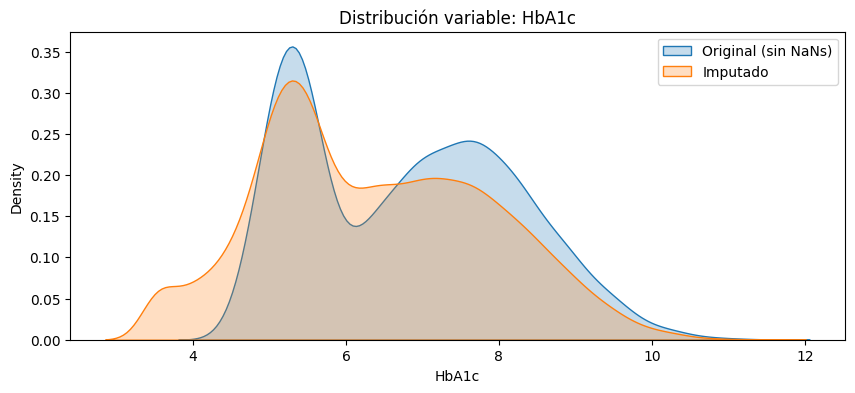

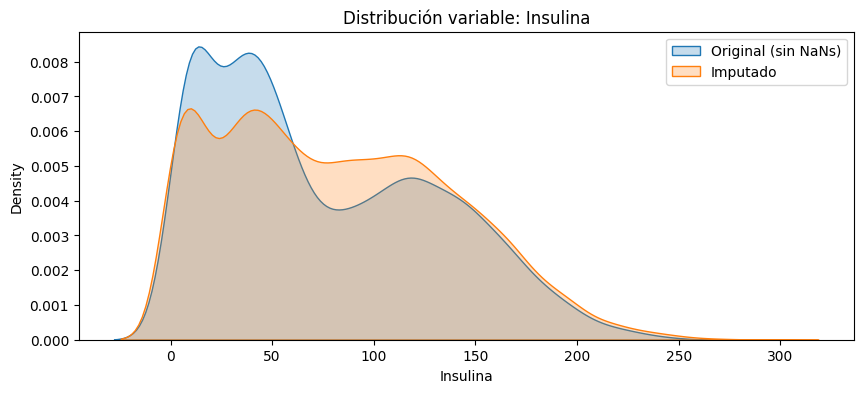

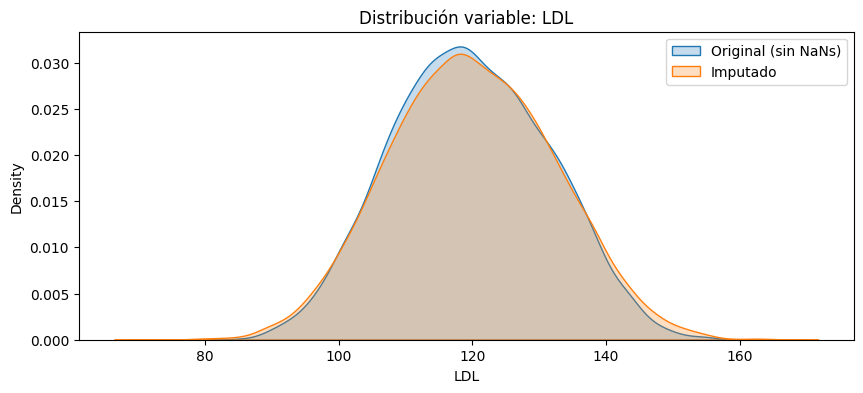

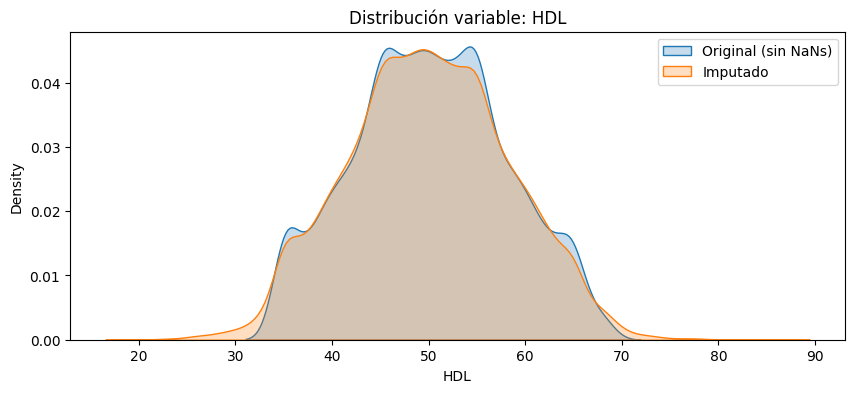

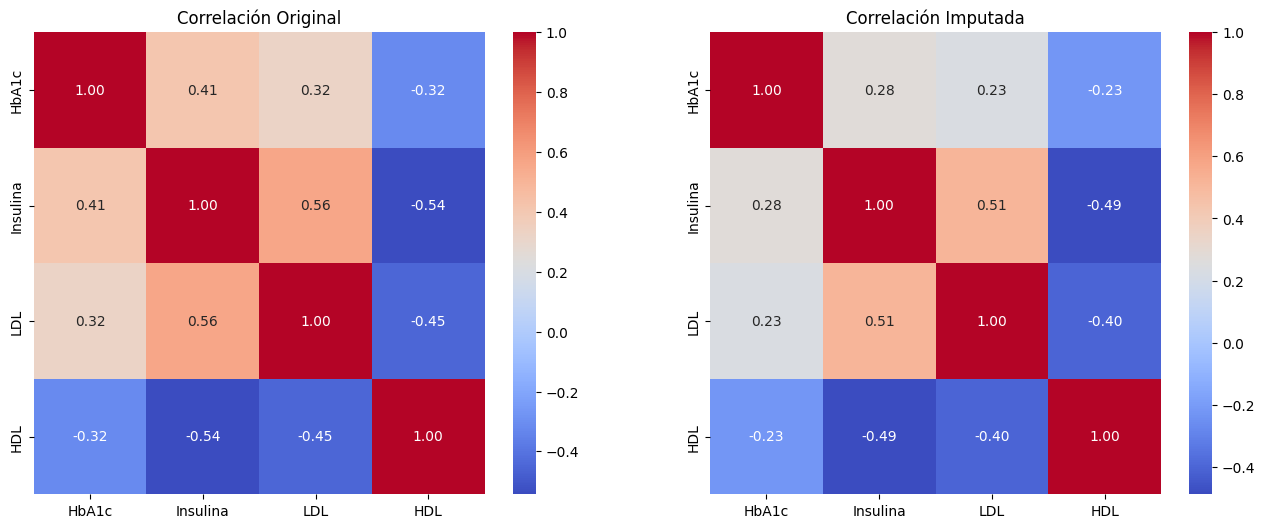

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def resumen_estadistico(df, variables):
    print("\nEstadísticas descriptivas de variables con imputación:")
    display(df[variables].describe())

def comparar_distribuciones(df_original, df_imputado, variables):
    for var in variables:
        plt.figure(figsize=(10,4))
        sns.kdeplot(df_original[var].dropna(), label='Original (sin NaNs)', fill=True)
        sns.kdeplot(df_imputado[var], label='Imputado', fill=True)
        plt.title(f"Distribución variable: {var}")
        plt.legend()
        plt.show()

def comparar_correlaciones(df_original, df_imputado, variables):
    corr_orig = df_original[variables].corr()
    corr_imput = df_imputado[variables].corr()
    
    fig, axes = plt.subplots(1, 2, figsize=(16,6))
    sns.heatmap(corr_orig, annot=True, fmt=".2f", cmap='coolwarm', ax=axes[0])
    axes[0].set_title("Correlación Original")
    sns.heatmap(corr_imput, annot=True, fmt=".2f", cmap='coolwarm', ax=axes[1])
    axes[1].set_title("Correlación Imputada")
    plt.show()

# --- Ejecutar análisis ---

# Variables que imputamos (numéricas con NaNs permitidas)
variables_a_analizar = ['HbA1c', 'Insulina', 'LDL', 'HDL']

print(f"\nVariables analizadas: {variables_a_analizar}")

# Estadísticas descriptivas comparadas
resumen_estadistico(df, variables_a_analizar)
resumen_estadistico(df_imputado, variables_a_analizar)

# Distribuciones (histogramas / kde plots) comparadas
comparar_distribuciones(df, df_imputado, variables_a_analizar)

# Correlaciones comparadas (solo variables imputadas)
comparar_correlaciones(df, df_imputado, variables_a_analizar)


In [8]:
def interpretar_diferencia_corr(diferencia):
    """
    Interpreta el tamaño del cambio en correlaciones:
    - <0.1: cambio pequeño, buena estabilidad.
    - 0.1 - 0.25: cambio moderado, revisar contexto.
    - >0.25: cambio grande, posible pérdida de coherencia.
    """
    if diferencia < 0.1:
        return "✅ Cambio pequeño, la correlación es estable."
    elif diferencia < 0.25:
        return "⚠️ Cambio moderado, conviene revisar el contexto y sentido clínico."
    else:
        return "❌ Cambio grande, puede indicar inconsistencia o error en imputación."

def print_comparacion_correlaciones_con_interpretacion(df_original, df_imputado, variables):
    print("\nComparación de correlaciones antes y después de imputar:")
    corr_orig = df_original[variables].corr()
    corr_imput = df_imputado[variables].corr()
    
    for var in variables:
        print(f"\nVariable: {var}")
        for otra_var in variables:
            if otra_var == var:
                continue
            c_orig = corr_orig.loc[var, otra_var]
            c_imput = corr_imput.loc[var, otra_var]
            diff = abs(c_orig - c_imput)
            interpretacion = interpretar_diferencia_corr(diff)
            print(f"  Con {otra_var}: Original={c_orig:.3f}, Imputado={c_imput:.3f}, Dif={diff:.3f} -> {interpretacion}")


# Uso:
variables_a_analizar = ['HbA1c', 'Insulina', 'LDL', 'HDL', 'Ingresos_Anuales']

# Comparación global
print_comparacion_correlaciones_con_interpretacion(df, df_imputado, variables_a_analizar[:-1])



Comparación de correlaciones antes y después de imputar:

Variable: HbA1c
  Con Insulina: Original=0.411, Imputado=0.278, Dif=0.133 -> ⚠️ Cambio moderado, conviene revisar el contexto y sentido clínico.
  Con LDL: Original=0.324, Imputado=0.235, Dif=0.089 -> ✅ Cambio pequeño, la correlación es estable.
  Con HDL: Original=-0.318, Imputado=-0.226, Dif=0.093 -> ✅ Cambio pequeño, la correlación es estable.

Variable: Insulina
  Con HbA1c: Original=0.411, Imputado=0.278, Dif=0.133 -> ⚠️ Cambio moderado, conviene revisar el contexto y sentido clínico.
  Con LDL: Original=0.561, Imputado=0.512, Dif=0.049 -> ✅ Cambio pequeño, la correlación es estable.
  Con HDL: Original=-0.543, Imputado=-0.489, Dif=0.054 -> ✅ Cambio pequeño, la correlación es estable.

Variable: LDL
  Con HbA1c: Original=0.324, Imputado=0.235, Dif=0.089 -> ✅ Cambio pequeño, la correlación es estable.
  Con Insulina: Original=0.561, Imputado=0.512, Dif=0.049 -> ✅ Cambio pequeño, la correlación es estable.
  Con HDL: Origina


📊 Comparación de correlaciones antes y después de imputar (por pares relevantes):



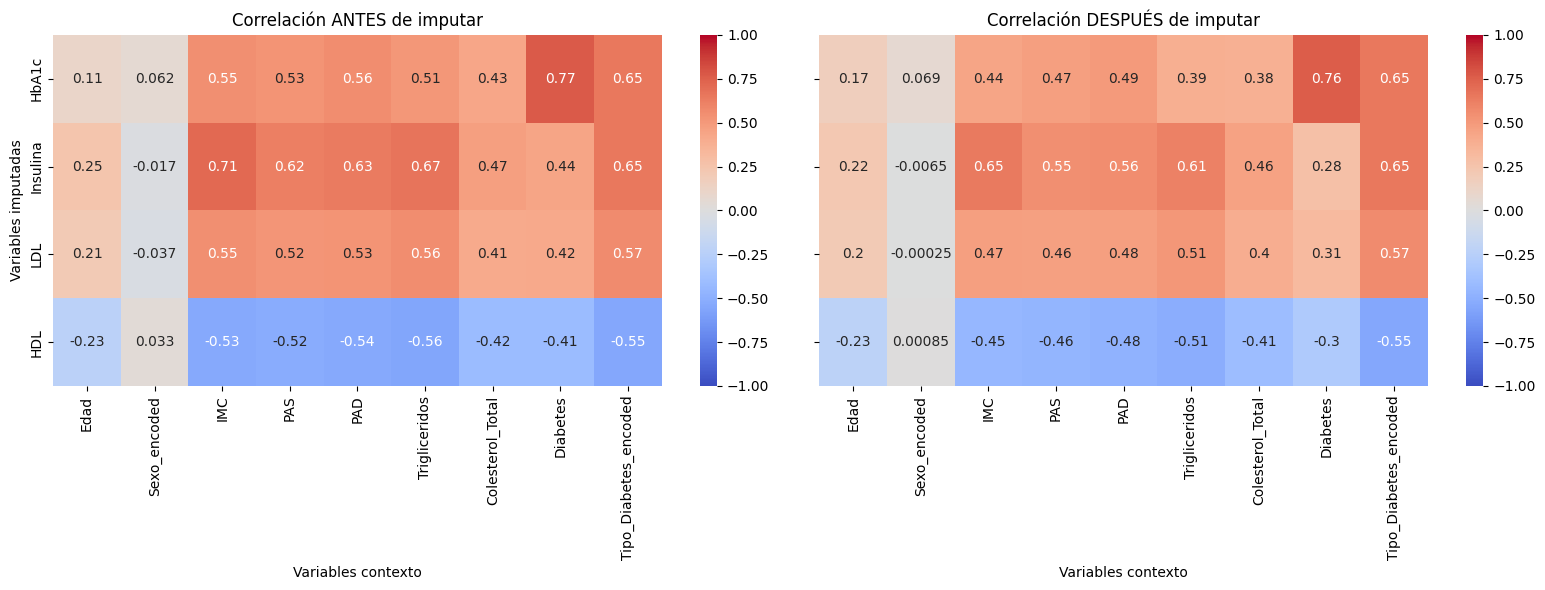


🔎 Variable imputada: HbA1c
  Con Edad: Original=0.108, Imputado=0.168, Dif=0.060 -> ✅ Cambio pequeño, la correlación es estable.
  Con Sexo_encoded: Original=0.062, Imputado=0.069, Dif=0.007 -> ✅ Cambio pequeño, la correlación es estable.
  Con IMC: Original=0.553, Imputado=0.439, Dif=0.115 -> ⚠️ Cambio moderado, conviene revisar el contexto y sentido clínico.
  Con PAS: Original=0.529, Imputado=0.472, Dif=0.057 -> ✅ Cambio pequeño, la correlación es estable.
  Con PAD: Original=0.562, Imputado=0.493, Dif=0.069 -> ✅ Cambio pequeño, la correlación es estable.
  Con Trigliceridos: Original=0.509, Imputado=0.385, Dif=0.124 -> ⚠️ Cambio moderado, conviene revisar el contexto y sentido clínico.
  Con Colesterol_Total: Original=0.430, Imputado=0.377, Dif=0.054 -> ✅ Cambio pequeño, la correlación es estable.
  Con Diabetes: Original=0.766, Imputado=0.760, Dif=0.005 -> ✅ Cambio pequeño, la correlación es estable.
  Con Tipo_Diabetes_encoded: Original=0.652, Imputado=0.652, Dif=0.000 -> ✅ Camb

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

def print_correlaciones_variables_clave(df_original, df_imputado, vars_imputadas, vars_complementarias):
    print("\n📊 Comparación de correlaciones antes y después de imputar (por pares relevantes):\n")

    variables = vars_imputadas + vars_complementarias
    corr_orig = df_original[variables].corr()
    corr_imput = df_imputado[variables].corr()

    # --- Submatrices específicas para los heatmaps ---
    heatmap_orig = corr_orig.loc[vars_imputadas, vars_complementarias]
    heatmap_imput = corr_imput.loc[vars_imputadas, vars_complementarias]

    # --- FIGURA CON DOS HEATMAPS EN PARALELO ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    sns.heatmap(heatmap_orig, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[0])
    axes[0].set_title("Correlación ANTES de imputar")
    axes[0].set_xlabel("Variables contexto")
    axes[0].set_ylabel("Variables imputadas")

    sns.heatmap(heatmap_imput, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[1])
    axes[1].set_title("Correlación DESPUÉS de imputar")
    axes[1].set_xlabel("Variables contexto")

    plt.tight_layout()
    plt.show()


    # --- COMPARACIÓN E INTERPRETACIÓN ---
    resumen = {
        "✅ Cambio pequeño, la correlación es estable.": 0,
        "⚠️ Cambio moderado, conviene revisar el contexto y sentido clínico.": 0,
        "❌ Cambio grande, puede indicar inconsistencia o error en imputación.": 0
    }

    for var_imp in vars_imputadas:
        print(f"\n🔎 Variable imputada: {var_imp}")
        for otra_var in vars_complementarias:
            try:
                c_orig = corr_orig.loc[var_imp, otra_var]
                c_imput = corr_imput.loc[var_imp, otra_var]
                diff = abs(c_orig - c_imput)
                interpretacion = interpretar_diferencia_corr(diff)

                resumen[interpretacion] += 1

                print(f"  Con {otra_var}: Original={c_orig:.3f}, Imputado={c_imput:.3f}, Dif={diff:.3f} -> {interpretacion}")
            except KeyError:
                print(f"  ⚠️ No se pudo calcular la correlación con {otra_var}.")

    # --- DIAGNÓSTICO FINAL ---
    print("\n\n📋 Diagnóstico final del análisis de estabilidad:")
    for key, count in resumen.items():
        print(f"  {key}: {count} pares")

    
variables_a_analizar = ['HbA1c', 'Insulina', 'LDL', 'HDL']
variables_contexto = ['Edad', 'Sexo_encoded', 'IMC', 'PAS', 'PAD',
                      'Trigliceridos', 'Colesterol_Total',
                      'Diabetes', 'Tipo_Diabetes_encoded']

print_correlaciones_variables_clave(df, df_imputado, variables_a_analizar, variables_contexto)


# DESCARTAMOS ❌ Ingresos_Anuales ❌ por relaciones insuficientes con el resto de variables

In [10]:
df_imputado

df_imputado = df_imputado.drop(columns='Ingresos_Anuales')

In [11]:
# Eliminar columnas que terminan en '_encoded' o empiezan por 'source_'
cols_to_drop = [col for col in df_imputado.columns if col.endswith('_encoded') or col.startswith('source_')]
df_final = df_imputado.drop(columns=cols_to_drop)

# Añadir variables originales desde df_precov_full
vars_to_add = ['Nivel_Estres', 'Actividad_Fisica', 'Riesgo_Cardiovascular', 'Consumo_Alcohol', 'Sexo', 'Diabetes', 'Tipo_Diabetes']
for var in vars_to_add:
    df_final[var] = df_precov_full[var]

df_final

,Año_Registro,Edad,IMC,Diabetes,Colesterol_Total,Trigliceridos,PAS,PAD,Cohorte,HbA1c,Insulina,LDL,HDL,Nivel_Estres,Actividad_Fisica,Riesgo_Cardiovascular,Consumo_Alcohol,Sexo,Tipo_Diabetes
0,2016,-0.804483,-0.362909,0,203.053597,-0.525838,-1.113528,-1.128432,cardio,5.483777,10.602855,111.284292,71.456754,Alto,Moderado,Bajo,No consume,Hombre,NaN
1,2013,1.050480,-2.271737,0,214.198250,0.114886,-0.658882,-1.507895,cardio,5.212008,56.952216,124.064267,48.292897,Moderado,Sedentario,Bajo,No consume,Mujer,NaN
2,2017,1.335859,0.097390,0,178.338545,-0.998805,-0.187398,-1.371288,cardio,6.750564,92.875636,123.757918,55.659980,Moderado,Moderado,Bajo,No consume,Mujer,NaN
3,2014,0.194343,1.868184,0,208.059981,-0.049786,1.336506,-0.308793,cardio,4.659614,188.637574,110.158158,54.487884,Moderado,Sedentario,Bajo,No consume,Mujer,NaN
4,2016,0.337033,-0.081596,1,260.781259,0.017413,0.418796,-0.490935,cardio,7.436320,66.564019,120.410972,52.990636,Moderado,Sedentario,Moderado,Bajo,Mujer,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,2017,-0.634414,-0.096697,1,210.750000,-0.361928,-0.692497,-0.478777,diabetes,5.840000,4.450000,96.230000,53.870000,NaN,NaN,NaN,NaN,Hombre,Tipo 1
15996,2012,-0.809270,0.745440,1,226.150000,0.743030,-0.274150,0.519960,diabetes,7.810000,79.930000,107.710000,43.000000,NaN,NaN,NaN,NaN,Hombre,Tipo 2
15997,2012,-0.109843,-0.426947,1,215.130000,-1.201495,-0.632733,-0.349528,diabetes,7.370000,12.610000,103.980000,50.240000,NaN,NaN,NaN,NaN,Hombre,Tipo 1
15998,2016,1.376441,-1.170009,1,228.540000,0.106274,0.436374,-0.373028,diabetes,8.100000,0.390000,108.890000,54.810000,NaN,NaN,NaN,NaN,Mujer,Tipo 1


In [12]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Año_Registro           16000 non-null  int64  
 1   Edad                   16000 non-null  float64
 2   IMC                    16000 non-null  float64
 3   Diabetes               16000 non-null  int64  
 4   Colesterol_Total       16000 non-null  float64
 5   Trigliceridos          16000 non-null  float64
 6   PAS                    16000 non-null  float64
 7   PAD                    16000 non-null  float64
 8   Cohorte                16000 non-null  object 
 9   HbA1c                  16000 non-null  float64
 10  Insulina               16000 non-null  float64
 11  LDL                    16000 non-null  float64
 12  HDL                    16000 non-null  float64
 13  Nivel_Estres           8000 non-null   object 
 14  Actividad_Fisica       8000 non-null   object 
 15  Ri

In [13]:
# Exportar el df como archivo csv
df_final.to_csv('db_cardiabetes.csv', index=False)
print("✅ Datos guardados en 'db_cardiabetes.csv'.")

✅ Datos guardados en 'db_cardiabetes.csv'.
